In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

# Lesson 5: Fine-Tuning

* In this classroom, the libraries have been already installed for you.
* If you would like to run this code on your own machine, you need to install the following:
    ```
    !pip install -q accelerate torch diffusers transformers comet_ml
    ```

### Set up Comet

* Here you will use the [HuggingFace DreamBooth](https://huggingface.co/docs/diffusers/en/training/dreambooth) training.

In [2]:
import comet_ml

In [3]:
comet_ml.init(anonymous=True)

COMET INFO: Comet is now logging experiments in anonymous mode, they will be publicly accessing by using the experiment url


### Import and prepare the model

In [4]:
import torch


# model_name = 'stabilityai/stable-diffusion-xl-base-1.0' # with bug, vae generates nan
model_name = 'runwayml/stable-diffusion-v1-5'

In [5]:
# Define hyperparameters

hyperparameters = {
    "instance_prompt": "a photo of a [V] man",
    "class_prompt": "a photo of a man",
    "seed": 4329,
    "pretrained_model_name_or_path": model_name,
    "resolution": 1024 if '-xl' in model_name else 512,
    "num_inference_steps": 50,
    "guidance_scale": 5.0,
    "num_class_images": 200,
    "prior_loss_weight": 1.0,
    "enable_xformers_memory_efficient_attention": False,
    "use_8bit_adam":  False,

}

* Set new **Comet** experiment

In [6]:
experiment = comet_ml.Experiment()

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/mnt/ssd2/xin/repo/Prompt-Engineering-for-Vision-Models/L5_Fine_Tuning_DreamBooth' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/magenta-fort-5177/anonymous-project/bebb944a5f7e4029a8c083571be62ee0



### Load images

In [7]:
from utils import DreamBoothTrainer

In [8]:
trainer = DreamBoothTrainer(hyperparameters)

05/03/2024 16:01:56 - INFO - utils - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16



#### Note
- The code that generates images requires a GPU to run.
- The code is left here in markdown, but if you have access to GPUs outside of the classroom, you can run it there.
- In the classroom, you'll still be able to follow along by retrieving the generated images from the experiment tracking tool (Comet).

In [9]:

# To run the training pipeline
trainer.generate_class_images()


{'image_encoder', 'requires_safety_checker'} was not found in config. Values will be initialized to default values.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded text_encoder as CLIPTextModel from `text_encoder` subfolder of runwayml/stable-diffusion-v1-5.
{'timestep_spacing', 'prediction_type'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
Loaded tokenizer as CLIPTokenizer from `tokenizer` subfolder of runwayml/stable-diffusion-v1-5.
Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
{'latents_mean', 'scaling_factor', 'latents_std', 'force_upcast'} was not found in config. Values will be initialized to default values.
Loaded vae as AutoencoderKL from `vae` subfolder of runwayml/stable-diffusion-v1-5.
{'upcast_attention', 'attention_type', 'time_embedding_dim', 'only_cross_attention', 'mid_block_only_cross_attention', 'num_class_embeds', 'addition_time_embed_dim', 'transformer_layers_per_block', 'class_embed_type', 'projection_class_embeddings_input_dim'

Generating class images:   0%|          | 0/50 [00:00<?, ?it/s]

In [10]:

# # To see the content of generate_class_image
# ??trainer.generate_class_images


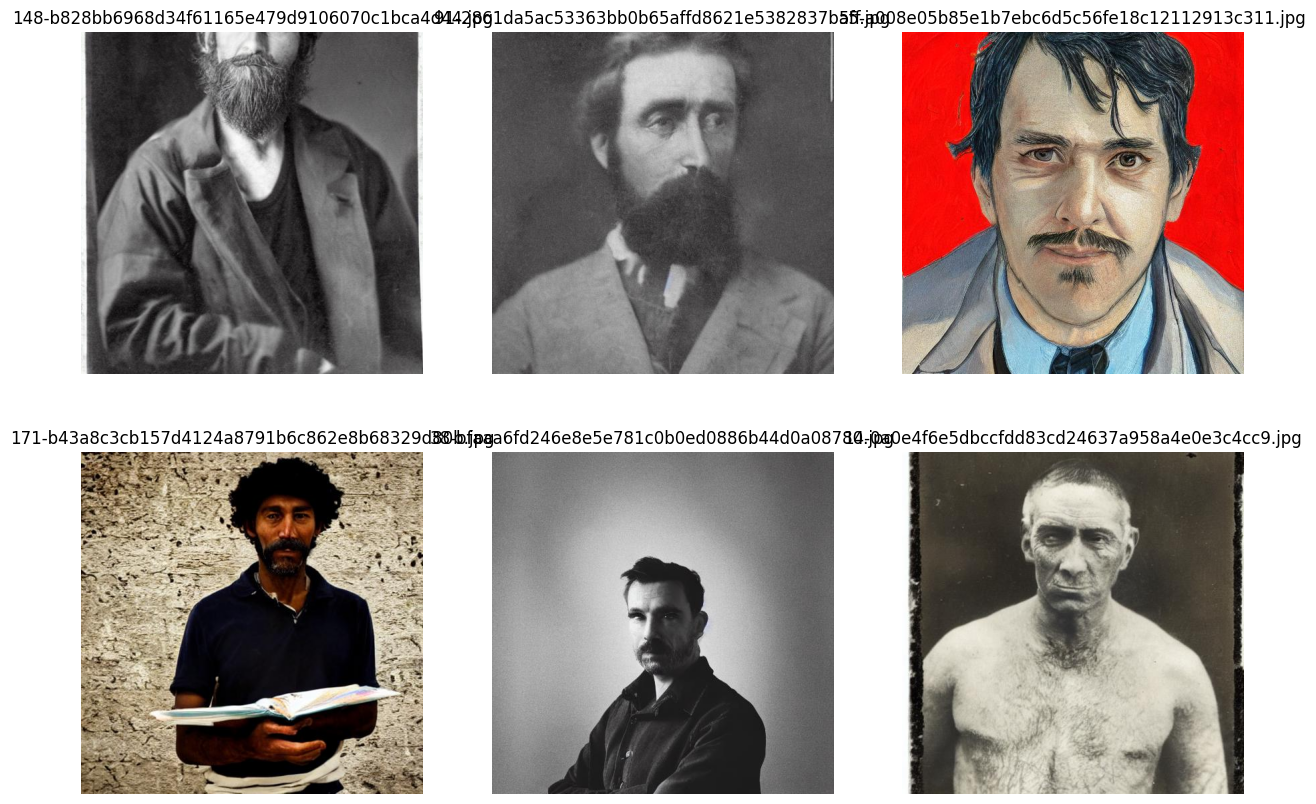

In [11]:
trainer.display_images("class")

#### Get class images (using artifacts).

In [12]:
import shutil

In [ ]:
# # Get images
# class_artifact = experiment.get_artifact('ckaiser/class-images-15')
# class_artifact.download('./')

In [ ]:
# shutil.unpack_archive('./class.zip', './class')

>Note: the images referenced in this notebook have already been uploaded to the Jupyter directory, in this classroom, for your convenience. For further details, please refer to the **Appendix** section located at the end of the lessons.

In [ ]:
# # Print some images
# trainer.display_images("class")

* Get the instance dataset (images of Andrew)

In [ ]:
andrew_artifact = experiment.get_artifact('ckaiser/andrew-dataset')
andrew_artifact.download('./')

In [ ]:
shutil.unpack_archive('./andrew-dataset.zip', './instance')

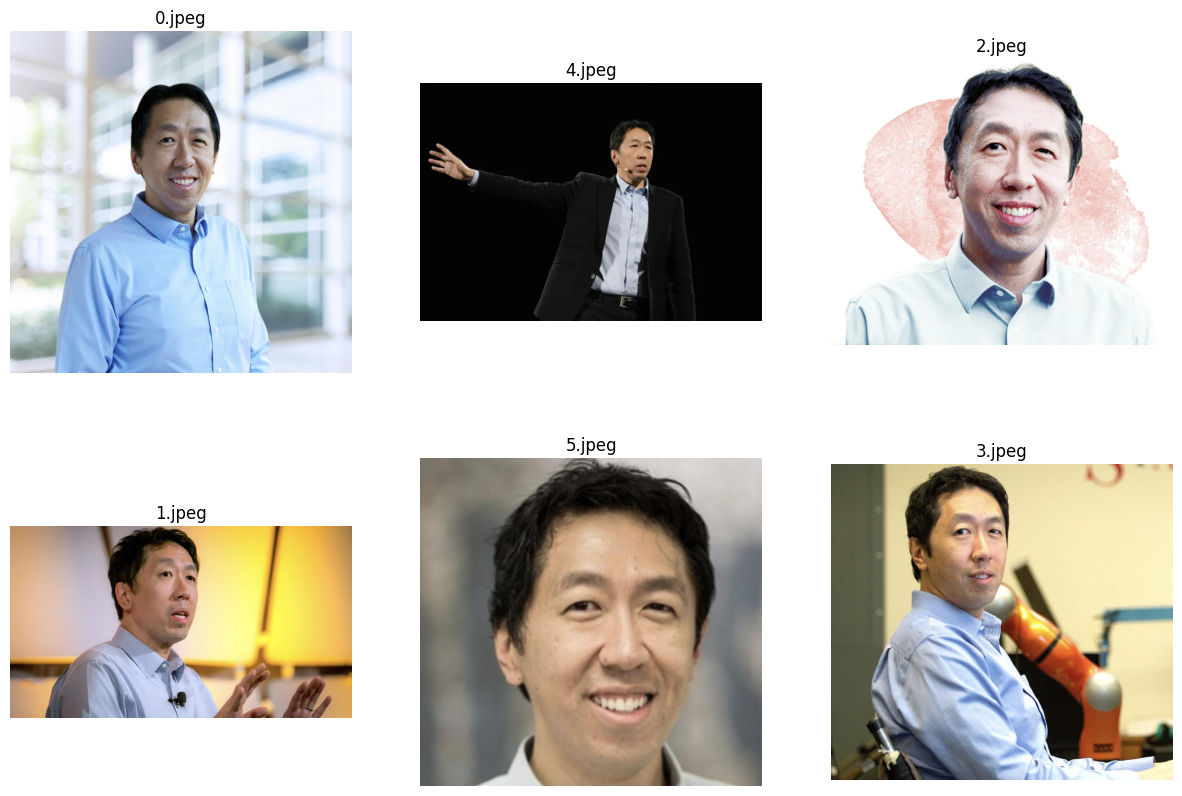

In [13]:
# Print some images
trainer.display_images("instance")

### Initialize the model
- It will take some time (several minutes) to initialize the model.

In [14]:
tokenizer, text_encoder, vae, unet = trainer.initialize_models()

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'latents_mean', 'scaling_factor', 'latents_std', 'force_upcast'} was not found in config. Values will be initialized to default values.
{'upcast_attention', 'attention_type', 'time_embedding_dim', 'only_cross_attention', 'mid_block_only_cross_attention', 'num_class_embeds', 'addition_time_embed_dim', 'transformer_layers_per_block', 'class_embed_type', 'projection_class_embeddings_input_dim', 'reverse_transformer_layers_per_block', 'resnet_time_scale_shift', 'cross_attention_norm', 'dropout', 'dual_cross_attention', 'time_embedding_act_fn', 'use_linear_projection', 'encoder_hid_dim_type', 'timestep_post_act', 'time_cond_proj_dim', 'addition_embed_type_num_heads', 'resnet_skip_time_act', 'conv_out_kernel', 'addition_embed_type', 'time_embedding_type', 'conv_in_kernel', 'mid_block_type', 'class_embeddings_concat', 'num_attention_heads

> Note: see the video lesson for the LoRA explanation.

In [15]:
# Add noise to generate images in Stable Diffusion
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler.from_pretrained(
    trainer.hyperparameters.pretrained_model_name_or_path,
    subfolder="scheduler"
)

{'variance_type', 'rescale_betas_zero_snr', 'thresholding', 'prediction_type', 'dynamic_thresholding_ratio', 'clip_sample_range', 'sample_max_value', 'timestep_spacing'} was not found in config. Values will be initialized to default values.


In [16]:
unet = trainer.initialize_lora(unet)

In [17]:
optimizer, params_to_optimize = trainer.initialize_optimizer(unet)

In [18]:
# Initialize the datasets
train_dataset, train_dataloader = trainer.prepare_dataset(tokenizer, text_encoder)
lr_scheduler = trainer.initialize_scheduler(train_dataloader, optimizer)

In [19]:
unet, optimizer, train_dataloader, lr_scheduler = trainer.accelerator.prepare(
    unet, optimizer, train_dataloader, lr_scheduler)

In [20]:
total_batch_size = \
    trainer.hyperparameters.train_batch_size * \
    trainer.hyperparameters.gradient_accumulation_steps

#### Note
- Starting from this point, the code demonstrated by the instructor will not execute in this notebook due to computational resource constraints. However, we provide the code here for you to run if you have access to a GPU or similar resources.
- Thank you for your understanding as we work to provide free and accessible courses.

In [21]:
from tqdm import tqdm


global_step = 0
epoch = 0

progress_bar = tqdm(
    range(0, trainer.hyperparameters.max_train_steps),
    desc="Steps"
)

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

In [25]:
import torch.nn.functional as F

In [27]:

for epoch in range(0, trainer.hyperparameters.num_train_epochs):
    unet.train()

    for step, batch in enumerate(train_dataloader):
        with trainer.accelerator.accumulate(unet):
            pixel_values = batch["pixel_values"].to(dtype=vae.dtype)
            model_input = vae.encode(pixel_values).latent_dist.sample()
            model_input = model_input * vae.config.scaling_factor

            noise = torch.randn_like(model_input)
            bsz, channels, height, width = model_input.shape

            timesteps = torch.randint(
                0,
                noise_scheduler.config.num_train_timesteps,
                (bsz,),
                device=model_input.device
            )

            timesteps = timesteps.long()
            noisy_model_input = noise_scheduler.add_noise(
                model_input,
                noise,
                timesteps
            )

            encoder_hidden_states = batch["input_ids"]

            model_pred = unet(
                noisy_model_input,
                timesteps,
                encoder_hidden_states,
                return_dict=False,
            )[0]

            target = noise

            model_pred, model_pred_prior = torch.chunk(model_pred, 2, dim=0)
            target, target_prior = torch.chunk(target, 2, dim=0)

            instance_loss = \
                F.mse_loss(
                    model_pred.float(),
                    target.float(),
                    reduction="mean"
                )
            
            prior_loss = \
                F.mse_loss(
                    model_pred_prior.float(),
                    target_prior.float(),
                    reduction="mean"
                )
            
            loss = \
                instance_loss + \
                trainer.hyperparameters.prior_loss_weight * \
                prior_loss
            
            trainer.accelerator.backward(loss)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            global_step +=1

        loss_metrics = {
            "loss": loss.detach().item,
            "prior_loss": prior_loss.detach().item,
            "lr": lr_scheduler.get_last_lr()[0],
        }

        experiment.log_metrics(loss_metrics, step=global_step)

        progress_bar.set_postfix(**loss_metrics)
        progress_bar.update(1)


        if global_step >= trainer.hyperparameters.max_train_steps:
            break

    trainer.save_lora_weights(unet)
experiment.add_tag(f"dreambooth-training")
experiment.log_parameters(trainer.hyperparameters)
trainer.accelerator.end_training()

COMET WARNING: Converting metric value '<built-in method item of Tensor object at 0x7ff7cc4a5c10>' into a string using str(), resulting string might be invalid
Steps: 100%|██████████| 500/500 [05:42<00:00,  2.02it/s, loss=<built-in method item of Tensor object at 0x7ff7ac2cf9c0>, lr=0.0005, prior_loss=<built-in method item of Tensor object at 0x7ff826fcad40>]Model weights saved in andrew-model/pytorch_lora_weights.safetensors


AttributeError: 'Experiment' object has no attribute 'log_parameteres'

#### Retrieve the training results
- You can get the training results using the experiment tracking tool, Comet.

In [29]:
training_experiment = \
    comet_ml.APIExperiment(
        previous_experiment="bebb944a5f7e4029a8c083571be62ee0"
    )


In [30]:
# See the experiment
training_experiment.display()


* Prompts to generate images of Andrew.

In [31]:
prompts = [
    "a photo of a [V] man playing basketball",
    "a photo of a [V] man riding a horse",
    "a photo of a [V] man at the summit of a mountain",
    "a photo of a [V] man driving a convertible",
    "a photo of a [V] man riding a skateboard on a huge halfpipe",
    "a mural of a [V] man, painted by graffiti artists"
]

validation_prompts = [
    "a photo of a man playing basketball",
    "a photo of a man riding a horse",
    "a photo of a man at the summit of a mountain",
    "a photo of a man driving a convertible",
    "a photo of a man riding a skateboard on a huge halfpipe",
    "a mural of a man, painted by graffiti artists"
]

#### Note
- The folowing code requires GPUs.

In [33]:

from diffusers import DiffusionPipeline

pipeline = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
pipeline.load_lora_weights("./andrew-model")

for prompt in prompts:
    with torch.no_grad():
        images = pipeline(
            prompt = prompt,
        ).images

        experiment.log_image(images[0], metadata={
            "prompt": prompt,
            "model": hyperparameters['pretrained_model_name_or_path'],
        })

for prompt in validation_prompts:
    with torch.no_grad():
        images = pipeline(
            prompt=prompt,
        ).images

    experiment.log_image(images[0], metadata={
            "prompt": prompt,
            "model": hyperparameters['pretrained_model_name_or_path'],
        })


{'image_encoder', 'requires_safety_checker'} was not found in config. Values will be initialized to default values.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loaded text_encoder as CLIPTextModel from `text_encoder` subfolder of runwayml/stable-diffusion-v1-5.
{'timestep_spacing', 'prediction_type'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
Loaded tokenizer as CLIPTokenizer from `tokenizer` subfolder of runwayml/stable-diffusion-v1-5.
Loaded safety_checker as StableDiffusionSafetyChecker from `safety_checker` subfolder of runwayml/stable-diffusion-v1-5.
Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
{'latents_mean', 'scaling_factor', 'latents_std', 'force_upcast'} was not found in config. Values will be initialized to default values.
Loaded vae as AutoencoderKL from `vae` subfolder of runwayml/stable-diffusion-v1-5.
{'upcast_attention', 'attention_type', 'time_embedding_dim', 'only_cross_attention', 'mid_block_only_cross_attention', 'num_class_embeds

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [35]:
pipeline.scheduler

PNDMScheduler {
  "_class_name": "PNDMScheduler",
  "_diffusers_version": "0.28.0.dev0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "timestep_spacing": "leading",
  "trained_betas": null
}

#### Retrieve the image generation results
- You can view the results of image generation regardless of whether you have access to GPUs, using the experiment tracking tool.

In [ ]:
inference_experiment = comet_ml.APIExperiment(
        previous_experiment="bebb944a5f7e4029a8c083571be62ee0"
    )


In [ ]:
# See the experiment
inference_experiment.display(tab="images")


### Additional Resources
* For more on how to use Comet for experiment tracking, check out this [Quickstart Guide](https://colab.research.google.com/drive/1jj9BgsFApkqnpPMLCHSDH-5MoL_bjvYq?usp=sharing) and the [Comet Docs](https://www.comet.com/docs/v2/).
* This course was based off a set of two blog articles from Comet. Explore them here for more on how to use newer versions of Stable Diffusion in this pipeline, additional tricks to improve your inpainting results, and a breakdown of the pipeline architecture:
  * [SAM + Stable Diffusion for Text-to-Image Inpainting](https://www.comet.com/site/blog/sam-stable-diffusion-for-text-to-image-inpainting/)
  * [Image Inpainting for SDXL 1.0 Base Model + Refiner](https://www.comet.com/site/blog/image-inpainting-for-sdxl-1-0-base-refiner/)

## Did you like this course?

- If you liked this course, could you consider giving a rating and share what you liked? 💕
- If you did not like this course, could you also please share what you think could have made it better? 🙏

#### A note about the "Course Review" page.
The rating options are from 0 to 10, and used to calculate the "Net Promoter Score"
- A score of 9 or 10 means you like the course.💫 💕
- A score of 7 or 8 means you feel neutral about the course (neither like nor dislike). 🙄
- A score of 0,1,2,3,4,5 or 6 all mean that you do not like the course. 😭 